In [47]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import scanpy as sc
import cassiopeia as cas
import seaborn as sns
import statistics as stats
import collections
import pickle
import scipy.sparse as sp_sparse
import scipy.io
import tables
import csv
import math

import matplotlib
from matplotlib.pyplot import rc_context
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from itertools import combinations
from itertools import product
from pylab import *
import ete3
from ete3 import Tree
from typing import Tuple

In [2]:
clusterColorsFile = "/Genomics/chanlab/mchan/Adriano/TLS/TLS_TLSCL/20211102_clusterColorsTLSCL.p"
with open(clusterColorsFile,'rb') as fp:
    colorDict = pickle.load(fp)

# Label the nodes in the tree

In [3]:
# Label internal nodes
def nameInteriorNodes(nwkFile,outnwkFile):

    t = Tree(nwkFile,format=1)
    labelID = 0

    for node in t.traverse():
        if node.is_leaf() == False:
            node.name = "node{}".format(labelID)
            labelID = labelID + 1

    t.write(format=8,outfile=outnwkFile)

In [4]:
def add_node0(nwkFile, outnwkFile):
    infile = open(nwkFile, 'r')
    outfile = open(outnwkFile, 'w')
    
    outfile.write(infile.readline()[:-1])
    outfile.write('node0;')
          
    infile.close()
    outfile.close()

In [5]:
def nodeClusterProfile(node, data, colName, df):
    if node.is_leaf():
        clusterID = data.loc[node.name,colName]
        df.loc[node.name,clusterID] = 1
        return 1
    else:
        daughters = node.children
        nodeNames = []
        for d in daughters:
            nodeClusterProfile(d,data,colName,df)
            nodeNames.append(d.name)
        df.loc[node.name,:] = df.loc[nodeNames,:].sum()
        return 1

In [6]:
def makeNodeMetaTable(nwkFile, metaFile, colName, outMetaFile):

    t = Tree(nwkFile,format=1)
    
    # get node names from tree;
    nodeNameList = []
    for node in t.traverse():
        nodeNameList.append(node.name)

    data = pd.read_csv(metaFile, sep='\t')
    data.set_index("cellBC", inplace=True)

    # best to initialize data frame with rows and columns when possible
    # (try not to grow dataframes)
    #clusterNames = data[colName].unique()
    clusterNames = ["['Somite']", "['Somite-1']", "['SomiteSclero']", "['NeuralTube1']", "['Somite0']", "['NeuralTube2']", 
                    "['NMPs']", "['SomiteDermo']", "['Unknown']", "['Endothelial']", "['pPSM']", "['aPSM']", "['PCGLC']",
                    "['Endoderm']"]

    df_meta = pd.DataFrame(columns = clusterNames, index = nodeNameList)
    df_meta.fillna(0, inplace = True)
    df_meta.index.name = "cellBC"

    nodeClusterProfile(t.get_tree_root(), data, colName, df_meta)
    df_meta.to_csv(outMetaFile, sep="\t")

In [7]:
def maxDepth(node):
    '''
    Input:
        - a node in an ete tree
    returns:
        - The max depth of any branch in that node
    '''
    if node.is_leaf():
        return 0
    children_depths = []
    
    for child in node.children:
        test = maxDepth(child)
        
        children_depths.append(test)
        
    return max(children_depths) + 1

In [ ]:
nameInteriorNodes(TLS1_loc, '/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/TLS1_node0_missing.txt')

add_node0('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/TLS1_node0_missing.txt',
         '/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/AM-DNA-097_hybrid_newick_noMutationlessEdges_Labeled.nwk')

In [8]:
makeNodeMetaTable('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/AM-DNA-097_hybrid_newick_noMutationlessEdges_Labeled.nwk',
                  '/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/AM-DNA-097_metadata.txt',
                  'cell_state',
                  '/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/AM-DNA-097_clusterTable.txt')

# Load the data

In [8]:
# Load the allele table, tree, and lineage table for TLS1
TLS1_allele_table = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/allele_table.txt', sep='\t')

TLS1_loc = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/AM-DNA-097_hybrid_newick_noMutationlessEdges_Labeled.nwk'
t = Tree(TLS1_loc, format=1)

lineage_table = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/AM-DNA-097_lineage_table.txt', sep = '\t')

In [9]:
# Load the cell states, single cell RNA seq, and cDNA data for TLS1
cell_state_table = pd.read_csv('/Genomics/chanlab/blaw/TLS/LineageTracer/scRNAseq/TLS_120h_1_cellBC_cellState.tsv', sep='\t')

cDNA = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/TLS1_cDNA_cvg.txt', sep = '\t')

TLS1 = sc.read_h5ad('/Genomics/chanlab/blaw/TLS/raw_data/scRNA/TLS12/TLS_120h_1.h5ad')

In [10]:
# Load the cassiopeia Tree
tree_meta = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/AM-DNA-097_metadata.txt', sep='\t')
character_matrix = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/AM-DNA-097_character_matrix.txt', sep='\t', index_col = 0)

prior_file = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/AM-DNA-097_priors.pickle'
with open(prior_file, 'rb') as f:
    priors = pickle.load(f)

TLS1_tree = cas.data.CassiopeiaTree(character_matrix=character_matrix, priors=priors, tree = t)

missing_proportion = (character_matrix == -1).sum(axis=0) / character_matrix.shape[0]
uncut_proportion = (character_matrix == 0).sum(axis=0) / character_matrix.shape[0]
n_unique_states = character_matrix.apply(lambda x: len(np.unique(x[(x != 0) & (x != -1)])), axis=0)

character_meta = pd.DataFrame([missing_proportion, uncut_proportion, n_unique_states], index = ['missing_prop', 'uncut_prop', 'n_unique_states']).T
TLS1_tree.cell_meta = tree_meta
TLS1_tree.character_meta = character_meta
TLS1_tree.parameters['stochastic_missing_probability'] = 0.1

In [11]:
intBCs = np.unique(TLS1_allele_table['intBC'])
cellBCs = np.unique(TLS1_allele_table['cellBC'])
leaves = [i.name for i in t.get_leaves()]

# Calculate and record tree specific statistics

In [12]:
n_of_cells = TLS1_tree.n_cell

In [13]:
n_of_clones = len(t.children)

In [14]:
# Calculate the depth and size for each clone in the tree (children of the root node)
clone_sizes = []
clone_max_depths = []

for clone in t.children:
    clone_sizes.append(len(clone))
    clone_max_depths.append(maxDepth(clone))

median_clone_size = stats.median(clone_sizes)
mean_clone_size = stats.mean(clone_sizes)
max_clone_size = max(clone_sizes)
mean_clone_depth = stats.mean(clone_max_depths)
max_clone_depth = max(clone_max_depths)

In [15]:
# Calculate the number of unique alleles and unique indels
unique_alleles = set()
unique_indels = set()
for allele in TLS1_allele_table['allele']:
    unique_alleles.add(allele)
for indel in TLS1_allele_table['r1']:
    unique_indels.add(indel)
for indel in TLS1_allele_table['r2']:
    unique_indels.add(indel)
for indel in TLS1_allele_table['r3']:
    unique_indels.add(indel)

n_of_unique_alleles = len(unique_alleles)
n_of_unique_indels = len(unique_indels)

In [16]:
indel_sites = ['CTTAATTCGCATTT_r1', 'CTTAATTCGCATTT_r2', 'CTTAATTCGCATTT_r3', 'AACTATTACATATA_r1', 'AACTATTACATATA_r2',
               'AACTATTACATATA_r3', 'GTCAGAACTTCTCC_r1', 'GTCAGAACTTCTCC_r2', 'GTCAGAACTTCTCC_r3', 'TTAACTGCCCGCTT_r1',
               'TTAACTGCCCGCTT_r2', 'TTAACTGCCCGCTT_r3', 'CAGCACGGGGTGCG_r1', 'CAGCACGGGGTGCG_r2', 'CAGCACGGGGTGCG_r3',
               'ACTTCTGTAATGTG_r1', 'ACTTCTGTAATGTG_r2', 'ACTTCTGTAATGTG_r3', 'ATCCGACTTATATC_r1', 'ATCCGACTTATATC_r2', 
               'ATCCGACTTATATC_r3', 'TAACTTTTGAGACA_r1', 'TAACTTTTGAGACA_r2', 'TAACTTTTGAGACA_r3', 'TCTTCAATAGTTTT_r1',
               'TCTTCAATAGTTTT_r2', 'TCTTCAATAGTTTT_r3', 'TGAGTGTAACACTG_r1', 'TGAGTGTAACACTG_r2', 'TGAGTGTAACACTG_r3']

In [17]:
lineage_table.fillna('[Null]', inplace = True)
lineage_table['lineageBC'] = lineage_table[indel_sites].apply("".join, axis=1)

In [18]:
# Calculate the number of unique lineage barcodes
unique_lineage_BC = set()

for row in lineage_table.iterrows():
    unique_lineage_BC.add(row[1]['lineageBC'])

n_of_unique_lineage_BC = len(unique_lineage_BC)

In [19]:
# Save all metrics to a text file
tree_stats = open('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/AM-DNA-097_Tree_Stats.txt', 'w')
tree_stats.write('Metric,Value\n')
tree_stats.write('n_of_cells,' + str(n_of_cells) + '\n')
tree_stats.write('n_of_clones,' + str(n_of_clones) + '\n')
tree_stats.write('median_clone_size,' + str(median_clone_size) + '\n') 
tree_stats.write('mean_clone_size,' + str(mean_clone_size) + '\n')
tree_stats.write('max_clone_size,' + str(max_clone_size) + '\n')
tree_stats.write('mean_clone_depth,' + str(mean_clone_depth) + '\n')
tree_stats.write('max_clone_depth,' + str(max_clone_depth) + '\n')
tree_stats.write('n_unique_indels,' + str(n_of_unique_indels) + '\n')
tree_stats.write('n_unique_alleles,' + str(n_of_unique_alleles) + '\n')
tree_stats.write('n_unique_lineage_BC,' + str(n_of_unique_lineage_BC) + '\n')
tree_stats.close()

# intBC recovery by cell state

In [20]:
# Count the number of intBC's are captured per cell in each cellstate
cell_state_intBC_counts = pd.DataFrame({'count': TLS1_allele_table.groupby([ "cell_state", "cellBC"]).size()}).reset_index()

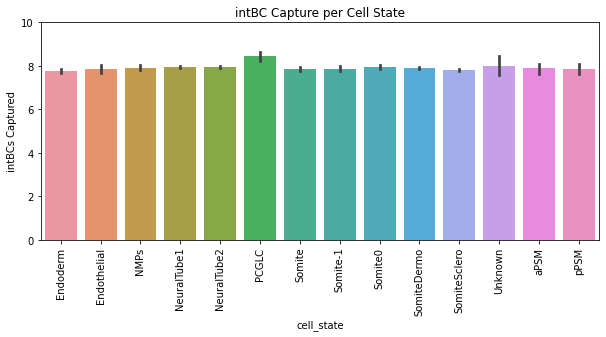

In [21]:
fig, ax = plt.subplots(figsize = (10, 4))

sns.barplot(data = cell_state_intBC_counts, x = 'cell_state', y = 'count')
plt.title('intBC Capture per Cell State')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('intBCs Captured')
ax.set_ylim(0, 10)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/intBC_capture_per_cell_state.pdf', dpi = 900)
plt.show()
plt.close()

# Investigate the shared alleles and lineage barcodes between cell states

In [22]:
lineage_table = lineage_table.merge(cell_state_table, how='left', left_on='cellBC', right_on='cellBC').copy()

In [23]:
tree_cells = []
for leaf in t.get_leaves():
    tree_cells.append(leaf.name)

In [24]:
tree_lineage_table = lineage_table[lineage_table['cellBC'].isin(tree_cells)]

In [25]:
aPSM_cells = lineage_table[lineage_table['cell_state'] == 'aPSM']['cellBC']
pPSM_cells = lineage_table[lineage_table['cell_state'] == 'pPSM']['cellBC']

In [26]:
lineageBC_fraq_per_cell = {}
lineageBC_per_cell = {}
for cell_state in colorDict.keys():
    lineageBC_fraq_per_cell[cell_state] = len(np.unique(tree_lineage_table[tree_lineage_table['cell_state'] == cell_state]['lineageBC'])) / len(tree_lineage_table[tree_lineage_table['cell_state'] == cell_state]['lineageBC'])
    lineageBC_per_cell[cell_state] = len(np.unique(tree_lineage_table[tree_lineage_table['cell_state'] == cell_state]['lineageBC']))

In [27]:
cell_order = dict(sorted(lineageBC_fraq_per_cell.items(), key=lambda item: item[1], reverse = True)).keys()

In [28]:
lineageBC_per_cell = dict(sorted(lineageBC_per_cell.items(), key=lambda item: item[1], reverse = True))

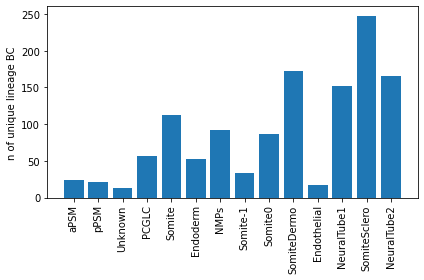

In [29]:
bar_order = []
for cell in cell_order:
    bar_order.append(lineageBC_per_cell[cell])

plt.bar(x=cell_order, height = bar_order)
plt.xticks(rotation=90)
plt.ylabel('n of unique lineage BC')
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/n_unique_lineageBC_per_state.pdf', dpi = 300)
plt.show()
plt.close()

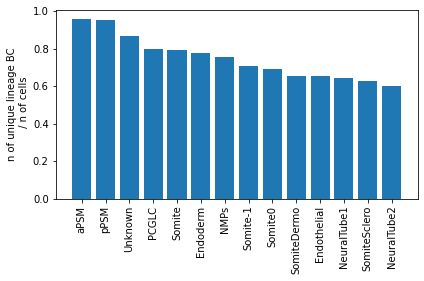

In [30]:
bar_order = []
for cell in cell_order:
    bar_order.append(lineageBC_fraq_per_cell[cell])

plt.bar(x=cell_order, height = bar_order)
plt.xticks(rotation=90)
plt.ylabel('n of unique lineage BC\n / n of cells')
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/fraq_unique_lineageBC_per_state.pdf', dpi = 300)
plt.show()
plt.close()

In [31]:
# histogram of the number of cell states that each allele appears in:
TLS1_allele_table.fillna('[Null]', inplace = True)
unique_alleles = np.unique(TLS1_allele_table['allele'])
n_state_counts = []
two_or_more = 0

for allele in unique_alleles:
    temp = TLS1_allele_table[TLS1_allele_table['allele'] == allele]
    n_states = len(np.unique(temp['cell_state']))
    n_state_counts.append(n_states)
    if n_states > 1:
        two_or_more += 1

two_or_more_fraq = two_or_more / len(unique_alleles)

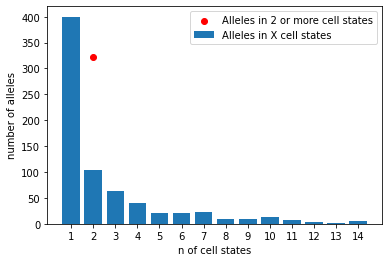

In [32]:
plt.scatter(x = 2, y = two_or_more, color = 'red')
plt.bar(x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], height = np.histogram(n_state_counts, bins = 14)[0])
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
plt.xlabel('n of cell states')
plt.ylabel('number of alleles')
plt.legend(['Alleles in 2 or more cell states', 'Alleles in X cell states'])
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/n_cell_states_per_allele_hist.pdf', dpi = 900)
plt.show()
plt.close()

In [33]:
# ranked bar plot with each allele as a x value and the heights being the number of cell states that they are in
TLS1_allele_table.fillna('[Null]', inplace = True)
unique_alleles = np.unique(TLS1_allele_table['allele'])
allele_IDs = []
n_states = []
count = 1

for allele in unique_alleles:
    temp = TLS1_allele_table[TLS1_allele_table['allele'] == allele]
    n_states.append(len(np.unique(temp['cell_state'])))
    allele_IDs.append(count)
    count += 1
    
allele_cell_states = dict(zip(allele_IDs, n_states))

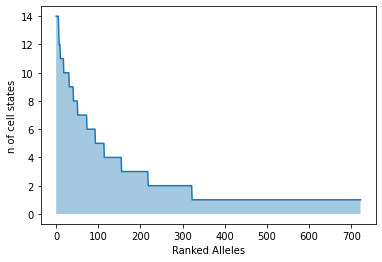

In [34]:
allele_cell_states = dict(sorted(allele_cell_states.items(), key=lambda item: item[1], reverse = True))
x = np.linspace(0, 722, 722)
y1 = allele_cell_states.values()

plt.plot(x, y1)
plt.xlabel('Ranked Alleles')
plt.ylabel('n of cell states')
plt.fill_between(x, y1, step="pre", alpha=0.4)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/n_cell_states_per_allele.pdf', dpi = 900)
plt.show()
plt.close()

In [35]:
# Make a table of the shared allele fractions per cell state
shared_allele_percents = pd.DataFrame.from_dict([lineageBC_per_cell])
shared_allele_percents.drop(index=0, inplace = True)

In [36]:
shared_allele_percents['cell_state'] = ''

for cell_state in colorDict.keys():
    temp = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    temp.append(cell_state)
    
    shared_allele_percents.loc[len(shared_allele_percents.index)] = temp

In [37]:
shared_allele_percents.set_index('cell_state', inplace = True)
shared_n_allele = shared_allele_percents.copy()

In [38]:
shared_allele_percents = shared_allele_percents.astype(float)

In [39]:
for cell_state in colorDict.keys():
    cell_state_df = TLS1_allele_table[TLS1_allele_table['cell_state'] == cell_state]
    cell_state_alleles = np.unique(cell_state_df['allele'])


    for test_state in colorDict.keys():
        test_state_df = TLS1_allele_table[TLS1_allele_table['cell_state'] == test_state]
        test_state_alleles = np.unique(test_state_df['allele'])
        
        total_unique_alleles = np.unique(np.concatenate((cell_state_alleles, test_state_alleles)))
        shared_alleles = np.intersect1d(cell_state_alleles, test_state_alleles)

        shared_allele_percents.loc[cell_state][test_state] = len(shared_alleles) / len(total_unique_alleles)
        shared_n_allele.loc[cell_state][test_state] = len(shared_alleles)

In [40]:
shared_allele_percents.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/shared_alleles_freq.csv')
shared_n_allele.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/shared_alleles_counts.csv')

# Clones specific statistics

In [55]:
# dictionaries to collect the number of cells and the number of nodes per root node
cells_per_clone = {}
nodes_per_clone = {}
clone_nodes = t.get_tree_root().children

In [56]:
# Count the number of nodes and leaves in each clone
for clone in clone_nodes:
    leaf_count = 0
    node_count = 0
    for node in clone.traverse():
        if node.is_leaf():
            leaf_count += 1
        else:
            node_count += 1
    cells_per_clone[clone.name] = leaf_count
    nodes_per_clone[clone.name] = node_count

In [57]:
cells_per_clone_df = pd.DataFrame.from_dict(cells_per_clone, orient = 'index')
nodes_per_clone_df = pd.DataFrame.from_dict(nodes_per_clone, orient = 'index')

In [58]:
cells_per_clone_df['Node'] = cells_per_clone_df.index
nodes_per_clone_df['Node'] = nodes_per_clone_df.index
merge = pd.merge(cells_per_clone_df, nodes_per_clone_df, on = 'Node')

In [60]:
merge.rename(columns = {'0_x':'Cells_per_Clone', '0_y':'Nodes_per_Clone'}, inplace = True)
merge.sort_values(ascending = False, by = 'Cells_per_Clone', inplace = True)
#merge.set_index('Node', inplace =True)
merge.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/clone_stats.csv')

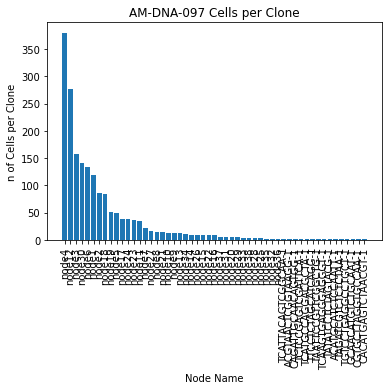

In [62]:
fig = plt.figure()
plt.bar(x = merge['Node'], height = merge['Cells_per_Clone'])
plt.title('AM-DNA-097 Cells per Clone')
plt.ylabel('n of Cells per Clone')
plt.xlabel('Node Name')
plt.xticks(rotation = 90)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/AM-DNA_097_Cells_per_Clones.pdf', dpi = 900)
plt.show()
plt.close()

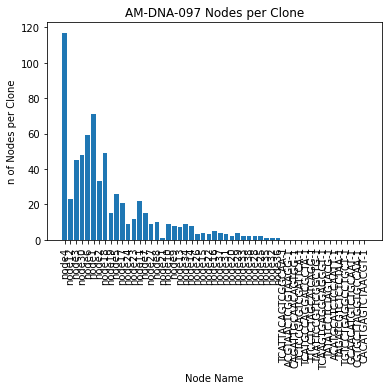

In [64]:
fig = plt.figure()
plt.bar(x = merge['Node'], height = merge['Nodes_per_Clone'])
plt.title('AM-DNA-097 Nodes per Clone')
plt.ylabel('n of Nodes per Clone')
plt.xlabel('Node Name')
plt.xticks(rotation = 90)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/AM-DNA_097_Nodes_per_Clones.pdf', dpi = 900)
plt.show()
plt.close()

# Plot the distribution of allelic distances between cells in the same sate and cells in seperate states
- Allele Distance = (2*(sites with different indels) + 1*(sites with indel vs uncut))/(number of sites recovered in both cells)

In [64]:
def calculate_allele_distance(cell_1, cell_2, lineage_table):
    '''
    input:
        The index barcode values for cell_1 and cell_2
        The lineage table that has the cellBC as the index values as well as the 30 target sites
    output:
        The allelic distance between the 2 lineage barcodes
        
    missing values (NaN) are taken as an indel
    '''
    cell_1_lineageBC = lineage_table.loc[cell_1].values[0:30]
    cell_2_lineageBC = lineage_table.loc[cell_2].values[0:30] 
    
    count = 0
    for i, indel in enumerate(cell_1_lineageBC):
        test_1 = cell_1_lineageBC[i]
        test_2 = cell_2_lineageBC[i]
        
        if str(test_1) == str(test_2):
            count += 0
        elif str(test_1) == '[None]' or str(test_2) == '[None]':
            count += 1
        else:
            count += 2
            
    return count

In [43]:
tree_lineage_table.set_index('cellBC', inplace = True)

In [44]:
cell_states = np.unique(tree_lineage_table['cell_state'])

In [69]:
for cell_state_1 in cell_states:
    cells_1 = tree_lineage_table[tree_lineage_table['cell_state'] == cell_state_1].index.values
    
    cell_state_distances = []
    cell_order = []
    
    for cell_state_2 in cell_states:
        cells_2 = tree_lineage_table[tree_lineage_table['cell_state'] == cell_state_2].index.values
        
        pair_distances = []
        
        for cell_1, cell_2 in ((cell_1, cell_2) for cell_1 in cells_1 for cell_2 in cells_2):
            allele_distance = calculate_allele_distance(cell_1, cell_2, tree_lineage_table)     
            pair_distances.append(allele_distance)
        
        cell_state_distances.append(pair_distances)
        cell_order.append(cell_state_2)
    
    fig, ax = plt.subplots()
    plt.boxplot(cell_state_distances)
    plt.title(cell_state_1 + '_Allelic_Distances')
    ax.set_xticklabels(cell_order, rotation = 90)
    plt.ylabel('Allelic Distance')
    plt.tight_layout()
    plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/pairwise_allelic_distance/' + cell_state_1 + '_Allelic_Distances.pdf', dpi = 300)
    #plt.show()
    plt.close()

# Correlate allelic distance and transcriptional distance

In [70]:
def calculate_transcriptional_correlation(cell_1, cell_2, corr_df):
    '''
    input:
        An array of the expression for cell_1 and cell_2
    returns:
        The pearson correlation between the two expression arrays
    '''
    return corr_df.loc['TLS_120h_rep1_' + cell_1]['TLS_120h_rep1_' + cell_2]

In [71]:
test_TLS1 = pd.DataFrame(TLS1.X.todense().T, columns = TLS1.obs.index.values, index = TLS1.var['features'].values)

In [72]:
geneList = ['Cxcl12','Nr2f1','Foxd2os','Ets1','Prrx2','Foxd2','Peg3','Twist1','Arg1','Fst',
            'Prrx2','Tpm1','Aldh1a2','Foxd1','Ppp1r1a','Meox1','Foxc2','Tcf15','Twist1','Fst',
            'Dll3','Lef1','Dll1','Fgf18','Rspo3','Pcdh19','Pcdh8','Notch1','Epb41l3','Synm',
            'Meox1', 'Tcf15', 'Prrx2','Pax3','Fst','Six1','Foxc2','Cadm1','Foxc1','Twist1',
            'Cdx2', 'Fgf8', 'Hoxc8', 'Hoxaas3', 'Hoxc6', 'Hoxb5os', 'Hoxb8', 'Epha5', 'Hoxc9', 'Lhpp',
            'Tpm1','Foxp1','Lef1', 'Ifitm1', 'Apip','Slc9a3r1','Notch1','Ppp1r1a','Fgf18','Laptm4b',
            'Crabp2', 'Ccnd2', 'Slc2a1', 'Fam181b', 'Sox21', 'Irx3', 'Sox3', 'Hoxaas3', 'Pax6', 'Hoxb9',
            'Rspo3','Gm45889','2610528A11Rik','Dll1','Hes7','Dll3','Sp5','Fgf8','Ptprz1','Frzb',
            'Igfbp5','Fxyd6','Nrtn','Nr2f2','Gas1','Tcf15','Tcf4','Cadm1','Phlda1','Pax3',
            'Cdx2', 'Hoxc8', 'Hoxc9', 'Hoxaas3', 'Slc2a1', 'Hoxb9', 'Gbx2', 'Sox3', 'Sox2', 'Epha5',
            'Lmo2', 'Kdr', 'Igfbp4', 'Inka1', 'Hhex', 'Etv2', 'Eva1b', 'Tmsb4x', 'Hopx', 'Cald1',
            'Krt8', 'Krt18', 'Igfbp2', 'Emb','Tagln2', 'Vtn','Foxa1','Trh','Cmtm8','Cldn6',
            'Dppa5a', 'Mt2', 'Hspb1', 'Mt1', 'L1td1', 'Dppa3', 'Ckb', 'Pou5f1', 'Ifitm3', 'Ldhb',
            'Ass1','Perp','Bst2','Malat1','Cyba','Ddit4','Btg2','Apoe','Phlda3','Cdkn1a']

In [73]:
markerList = ['Cxcl12', 'Peg3', 'Nr2f1', 'Prrx2', 'Twist1', 'Meox1', 'Foxd1', 'Arg1', 'Fst', 'Meg3', 'Igfbp5', 'Fxyd6', 'Nrtn', 
           'Cadm1', 'Gas1', 'Tcf15', 'Phlda1', 'Gm26917','Fam181b','Crabp2', 'Ccnd2', 'Sox3', 'Slc2a1', 'Hoxb9',
           'Hoxaas3', 'Hoxb5os', 'Id3', 'Hoxc9', 'Hoxc8', 'Cdx2', 'Sox2', 'Hoxb8', 'Uncx', 'Pax3', 'Crabp1', 'Fstl1', 'Ldha', 
           'Tpm1', 'Aldh1a2', 'Slc45a4', 'Fgf8', 'Epha5', 'Rspo3', 'Car4', 'Spink1', 'Krt8', 'Nepn', 'Krt18', 'Epcam', 'Trh',
           'Igfbp2', 'Emb', 'Slc2a3', 'Hspb1', 'Dppa3', 'Klf2', 'Pou5f1', 'Mylpf', 'Dppa5a', 'Mt2', 'Ifitm3', 'Ckb', 'Mt1', 
           'Pcdh19', 'Slc9a3r1', 'Foxp1', 'Lef1', 'Ifitm1', 'Notch1', 'Apip', 'Kdr', 'Lmo2', 'Hhex', 'Etv2', 'Igfbp4', 'Ramp2',
           'Tmsb4x', 'Egfl7', 'Vim', 'Sparc','Ripply2','Pcdh8', 'Dll1', 'Gm45889', 'Hes7', 'Sp5', 'Ass1', 'Btg2', 'Cdkn1a',
           'Phlda3', 'Apoe', 'Malat1', 'Mdm2']

In [74]:
test_tree_cells = []
for i in tree_cells:
    test_tree_cells.append('TLS_120h_rep1_' + i)

In [75]:
test_TLS1 = test_TLS1.loc[geneList, test_tree_cells] 

In [76]:
r_df = test_TLS1.corr(method='pearson', min_periods=10)
r = r_df.values

In [77]:
#num_trials = 500000
distances_dict = {}
bins_dict = {0:[], 1:[], 2:[]}
for i in range(60):
    distances_dict[i/30] = []

test = list(combinations(tree_cells, 2))

for cell_1, cell_2 in test:
    #cell_1 = np.random.choice(tree_lineage_table.index.values)
    #cell_2 = np.random.choice(tree_lineage_table.index.values)
    
    allele_distance = calculate_allele_distance(cell_1, cell_2, tree_lineage_table) / 30
    lineage_distance = calculate_transcriptional_correlation(cell_1, cell_2, r_df)
    
    distances_dict[allele_distance].append(lineage_distance)
    
    if allele_distance == 0:
        bins_dict[0].append(lineage_distance)
    elif allele_distance > 1/30:
        bins_dict[2].append(lineage_distance)
    else:
        bins_dict[1].append(lineage_distance)

In [78]:
distances_df = pd.DataFrame({key:pd.Series(value) for key, value in distances_dict.items()})
bins_df = pd.DataFrame({key:pd.Series(value) for key, value in bins_dict.items()})

/tmp/ipykernel_83246/1196111039.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  distances_df = pd.DataFrame({key:pd.Series(value) for key, value in distances_dict.items()})


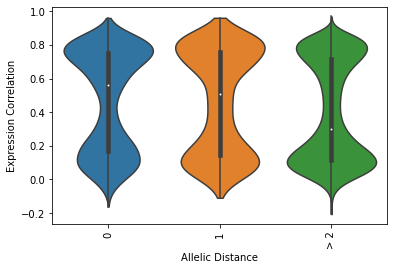

In [92]:
fig, ax = plt.subplots()
sns.violinplot(data = bins_df, cut = 0, scale = 'width')
ax.set_xticklabels(['0', '1', '> 2'], rotation = 90)
#ax.set_title('Edited Cells Allelic Distances')
#ax.set_ylabel('Allelic Distance')
ax.set_xlabel('Allelic Distance')
ax.set_ylabel('Expression Correlation')
ax.grid(False)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/Allelic_Distance_vs_Expression_bins_width.pdf', dpi = 300)
plt.show()
plt.close()

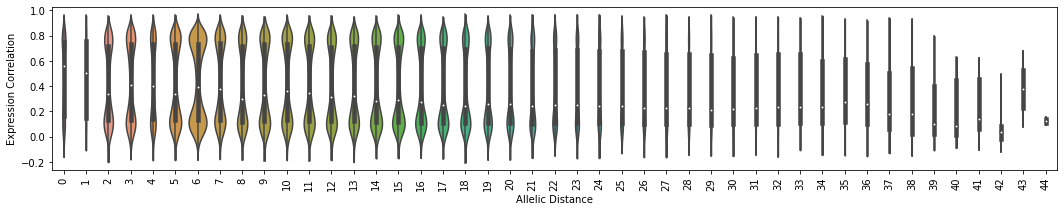

In [96]:
fig, ax = plt.subplots(figsize = (18, 3))
sns.violinplot(data = distances_df[distances_df.columns[0:45]], cut = 0, scale = 'count')
ax.set_xticklabels(ax.get_xticks(), rotation = 90)
#ax.set_title('Edited Cells Allelic Distances')
#ax.set_ylabel('Allelic Distance')
ax.set_xlabel('Allelic Distance')
ax.set_ylabel('Expression Correlation')
ax.grid(False)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/Allelic_Distance_vs_Expression.pdf', dpi = 300)
plt.show()
plt.close()

# Phylogenetic distance vs allele distance
- Phylogenetic distance is calculated as branch distance between 2 cells
- Allelic distance is calculated as above

In [107]:
df_pairwiseTreeDist = pd.read_csv("/Genomics/chanlab/mchan/Adriano/TLS/TLS_1_2/20220721_AM-DNA-097_TLS1_PairwiseBranchDistArgo.txt", index_col = 0, sep = "\t")

In [104]:
test_pairs = list(combinations(tree_cells, 2))

allelic_distances = np.zeros(len(test_pairs))
tree_distances = np.zeros(len(test_pairs))

count = 0
for cell_1, cell_2 in test_pairs:
    allelic_distances[count] = calculate_allele_distance(cell_1, cell_2, tree_lineage_table)
    tree_distances[count] = df_pairwiseTreeDist.loc[cell_1, cell_2]
    count += 1

In [108]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(allelic_distances, tree_distances)

In [110]:
print(r_value)

0.45245138904841303


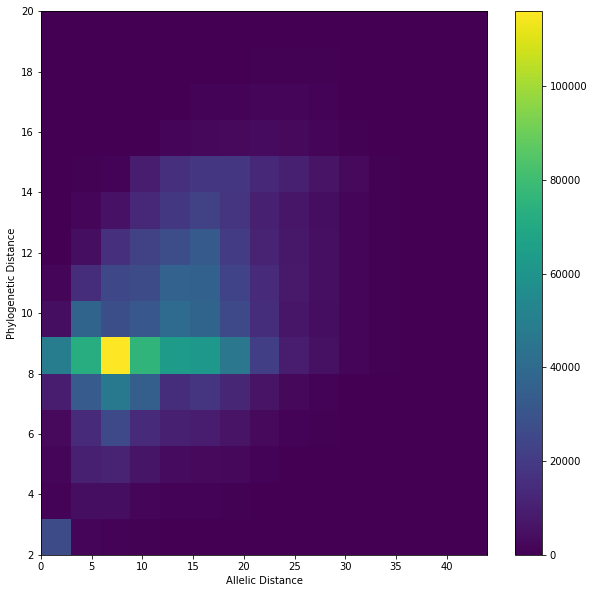

In [106]:
fig, ax = plt.subplots(figsize = (10, 10))

heatmap, xedges, yedges = np.histogram2d((allelic_distances), 
                                         (tree_distances), 
                                         bins = 15)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap = 'viridis', aspect = 'auto')
plt.xlabel('Allelic Distance')
plt.ylabel('Phylogenetic Distance')
plt.colorbar()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/Allelic_Distance_vs_Phylogenetic.pdf', dpi = 300)
plt.show()
plt.close()

# Plot cell state proportions split by edited and non-edited

In [111]:
all_cells = set(TLS1_allele_table['cellBC'])

In [112]:
unEditedSet = set(TLS1_allele_table['cellBC'])

for index, row in TLS1_allele_table.iterrows():
    if row['allele'] != '[None][None][None]':
        if row['cellBC'] in unEditedSet:
            unEditedSet.remove(row['cellBC'])

tableEdited = TLS1_allele_table[~TLS1_allele_table['cellBC'].isin(unEditedSet)]
tableNotEdited = TLS1_allele_table[TLS1_allele_table['cellBC'].isin(unEditedSet)]

In [113]:
print('The full allele table has:', str(len(np.unique(TLS1_allele_table['cellBC']))), 'cells')
print('There are:', str(len(np.unique(tableEdited['cellBC']))), 'edited cells')
print('There are:', str(len(np.unique(tableNotEdited['cellBC']))), 'unedited cells')

The full allele table has: 3210 cells
There are: 1836 edited cells
There are: 1374 unedited cells


In [114]:
TLS1_edited_cell_state_percent = {}
TLS1_unedited_cell_state_percent = {}
cell_states = colorDict.keys()

In [115]:
TLS1_edited_total = len(tableEdited['cell_state'])
TLS1_unedited_total = len(tableNotEdited['cell_state'])

for cell_state in cell_states:
    TLS1_edited_cell_state_percent[cell_state] = 100 * len(tableEdited[tableEdited['cell_state'] == cell_state]) / TLS1_edited_total
    TLS1_unedited_cell_state_percent[cell_state] = 100 * len(tableNotEdited[tableNotEdited['cell_state'] == cell_state]) / TLS1_unedited_total

In [116]:
cell_percents = pd.DataFrame.from_dict([TLS1_edited_cell_state_percent, TLS1_unedited_cell_state_percent])
cell_percents = cell_percents.rename(index = {0: "TLS1_Edited", 1: "TLS1_Unedited"})

In [117]:
colors = []
for color in cell_percents.columns:
    colors.append(colorDict[color])

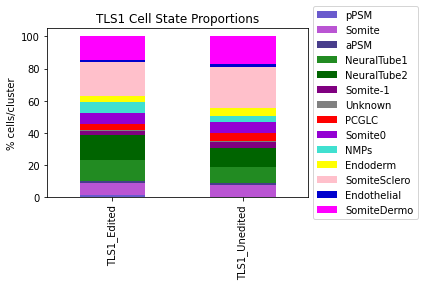

In [119]:
cell_percents.plot(kind='bar', use_index = True, stacked=True, color = colors, grid = False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('TLS1 Cell State Proportions')
plt.ylabel('% cells/cluster')
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/TLS_1_Edited_vs_Unedited_Cell_Percents.pdf', dpi = 300)
plt.show()
plt.close()

# Plot stacked bars of cell states for each clone

In [124]:
clone_leaves = {}

for clone in t.children:
    clone_leaves[clone.name] = clone.get_leaves()

In [125]:
clone_cell_states = cell_percents.copy()
clone_cell_states.drop(index = ['TLS1_Edited', 'TLS1_Unedited'], inplace = True)
clone_cell_states['total'] = ''
clone_cell_states['clone'] = ''

In [126]:
cell_state_dict = {'pPSM' : 0, 'Somite' : 1, 'aPSM' : 2, 'NeuralTube1' : 3, 'NeuralTube2' : 4, 'Somite-1' : 5,
                   'Unknown' : 6, 'PCGLC' : 7, 'Somite0' : 8, 'NMPs' : 9, 'Endoderm' : 10, 'SomiteSclero' : 11, 
                   'Endothelial' : 12, 'SomiteDermo' : 13}

In [127]:
for clone in clone_leaves.keys():
    total_cells = len(clone_leaves[clone])
    clone_cell_counts = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    for leaf in clone_leaves[clone]:
        cell_state = np.unique(TLS1_allele_table[TLS1_allele_table['cellBC'] == leaf.name]['cell_state'])
        clone_cell_counts[cell_state_dict[cell_state[0]]] += 1
    clone_cell_counts[14] = total_cells
    clone_cell_counts.append(clone)
    
    clone_cell_states.loc[len(clone_cell_states.index)] = clone_cell_counts

In [128]:
clone_cell_states.set_index('clone', inplace = True)

In [132]:
clone_cell_states.sort_values('total', ascending = False, inplace = True)
clone_cell_states.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/cell_states_per_clone.csv')

In [133]:
clone_cell_states_freq = clone_cell_states.copy()
clone_cell_states_freq = clone_cell_states_freq[clone_cell_states_freq.columns[:-1]].div(clone_cell_states_freq.total, axis=0)

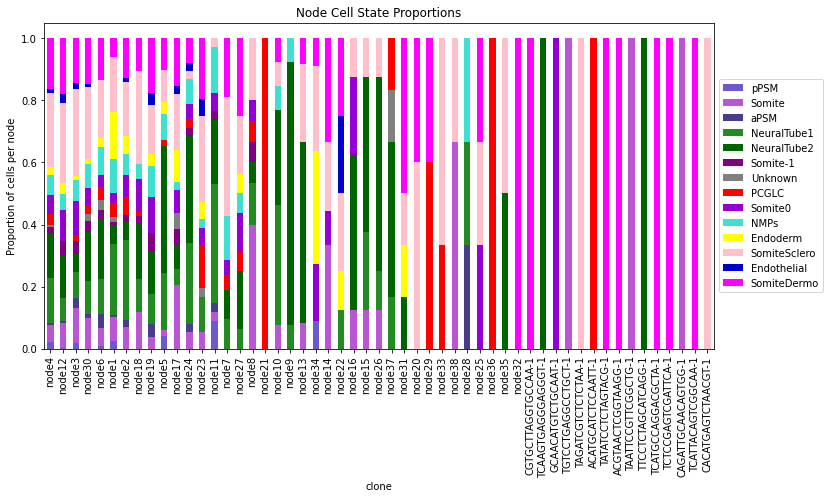

In [136]:
clone_cell_states_freq.plot(kind='bar', use_index = True, stacked=True, color = colors, grid = False, figsize = (12, 6))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Node Cell State Proportions')
plt.ylabel('Proportion of cells per node')
#plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/TLS_1_Clone_cell_state_proportions.pdf', dpi = 900)
plt.show()
plt.close()

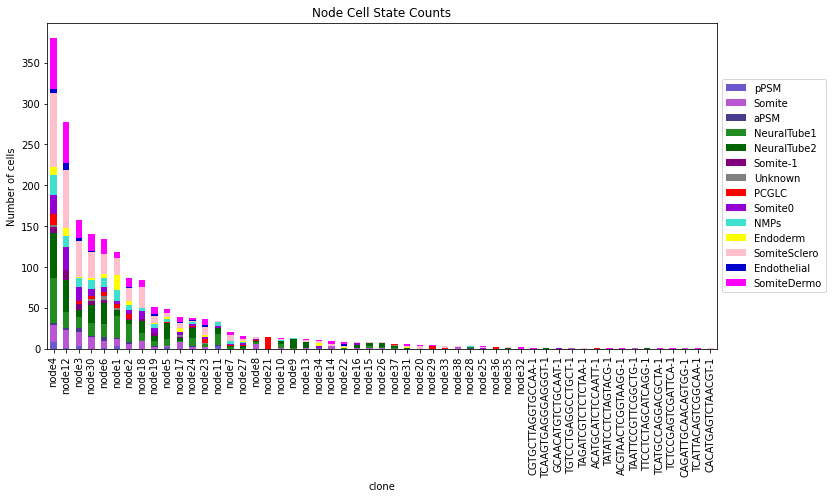

In [137]:
test = clone_cell_states.copy()
test.drop(columns = ['total'], inplace = True)
test.plot(kind='bar', use_index = True, stacked=True, color = colors, grid = False, figsize = (12, 6))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Node Cell State Counts')
plt.ylabel('Number of cells')
#plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/TLS_1_Clone_cell_state_counts.pdf', dpi = 900)
plt.show()
plt.close()

### Plot the cDNA vs intBC capture

In [139]:
total_cells = len(np.unique(TLS1_allele_table['cellBC']))
percent_cells = {}

intBCs = ['AACTATTACATATA', 'ACTTCTGTAATGTG', 'ATCCGACTTATATC', 'CAGCACGGGGTGCG', 'CTTAATTCGCATTT', 'GTCAGAACTTCTCC', 
          'TAACTTTTGAGACA', 'TCTTCAATAGTTTT', 'TGAGTGTAACACTG', 'TTAACTGCCCGCTT']

for intBC in intBCs:
    intBC_cell_count = len(np.unique(TLS1_allele_table[TLS1_allele_table['intBC'] == intBC]['cellBC']))
    percent_cells[intBC] = (100 * intBC_cell_count / total_cells)

In [140]:
percent_cells

{'AACTATTACATATA': 99.78193146417445,
 'ACTTCTGTAATGTG': 99.34579439252336,
 'ATCCGACTTATATC': 98.78504672897196,
 'CAGCACGGGGTGCG': 99.4392523364486,
 'CTTAATTCGCATTT': 99.84423676012462,
 'GTCAGAACTTCTCC': 99.59501557632399,
 'TAACTTTTGAGACA': 70.62305295950156,
 'TCTTCAATAGTTTT': 19.221183800623052,
 'TGAGTGTAACACTG': 3.8317757009345796,
 'TTAACTGCCCGCTT': 99.50155763239876}

In [141]:
intBC_cell_percents = []
cDNA_average_values = []

for intBC in intBCs:
    intBC_cell_percents.append(percent_cells[intBC])
    cDNA_average_values.append(float('.'.join(cDNA[intBC][7].split(','))))

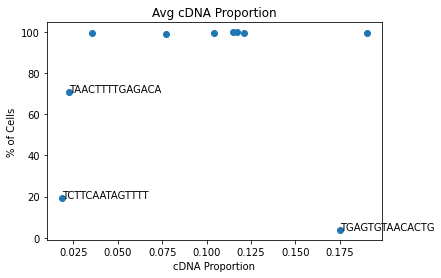

In [142]:
plt.scatter(y = intBC_cell_percents, x = cDNA_average_values)

to_label = ['TAACTTTTGAGACA', 'TCTTCAATAGTTTT', 'TGAGTGTAACACTG']

for i, label in enumerate(intBCs):
    if label in to_label:
        plt.annotate(label, (cDNA_average_values[i], intBC_cell_percents[i]))
        
plt.xlabel('cDNA Proportion')
plt.ylabel('% of Cells')
plt.title('Avg cDNA Proportion')
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/1_preprocessing/QC/intBC_Capture_vs_cDNA_proportion.pdf', dpi = 900)
plt.show()
plt.close()